In [1]:
%matplotlib inline

In [3]:
!pip install pennylane

     |████████████████████████████████| 522kB 24.3MB/s 


In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from google.colab import drive

Setting of the main hyper-parameters of the model
=================================================


In [6]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "drive/MyDrive/quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset
============================


In [8]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11493376/11490434 [==============================] - 0s 0us/step


Quantum circuit as a convolution kernel
=======================================

In [9]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [12]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


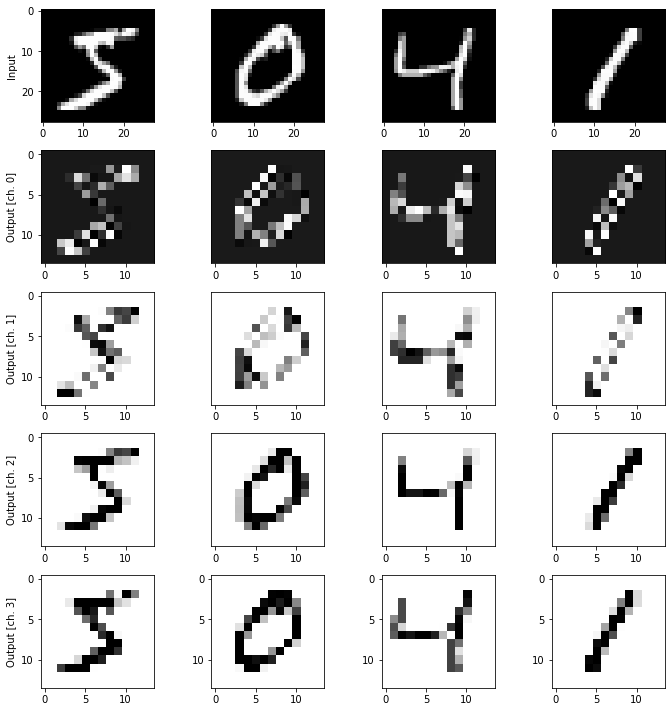

In [13]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Hybrid quantum-classical model
==============================

In [14]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

In [15]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - loss: 2.9351 - accuracy: 0.1000 - val_loss: 2.3946 - val_accuracy: 0.1000
Epoch 2/30
13/13 - 0s - loss: 2.1241 - accuracy: 0.2800 - val_loss: 2.1525 - val_accuracy: 0.2000
Epoch 3/30
13/13 - 0s - loss: 1.7218 - accuracy: 0.5600 - val_loss: 2.0267 - val_accuracy: 0.3333
Epoch 4/30
13/13 - 0s - loss: 1.3012 - accuracy: 0.6400 - val_loss: 1.7713 - val_accuracy: 0.4000
Epoch 5/30
13/13 - 0s - loss: 1.0990 - accuracy: 0.8000 - val_loss: 1.6480 - val_accuracy: 0.4333
Epoch 6/30
13/13 - 0s - loss: 0.9181 - accuracy: 0.8000 - val_loss: 1.6461 - val_accuracy: 0.3667
Epoch 7/30
13/13 - 0s - loss: 0.7147 - accuracy: 0.9400 - val_loss: 1.5006 - val_accuracy: 0.4667
Epoch 8/30
13/13 - 0s - loss: 0.5779 - accuracy: 0.9600 - val_loss: 1.4361 - val_accuracy: 0.5333
Epoch 9/30
13/13 - 0s - loss: 0.4889 - accuracy: 0.9600 - val_loss: 1.4047 - val_accuracy: 0.4667
Epoch 10/30
13/13 - 0s - loss: 0.3953 - accuracy: 1.0000 - val_loss: 1.3868 - val_accuracy: 0.6000
Epoch 11/30
13/13 -

In [16]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000
Epoch 4/30
13/13 - 0s - loss: 1.4920 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333
Epoch 9/30
13/13 - 0s - loss: 0.7474 - accuracy: 0.9400 - val_loss: 1.4564 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.6632 - accuracy: 0.9600 - val_loss: 1.4129 - val_accuracy: 0.7000
Epoch 11/30
13/13 -

Results
=======

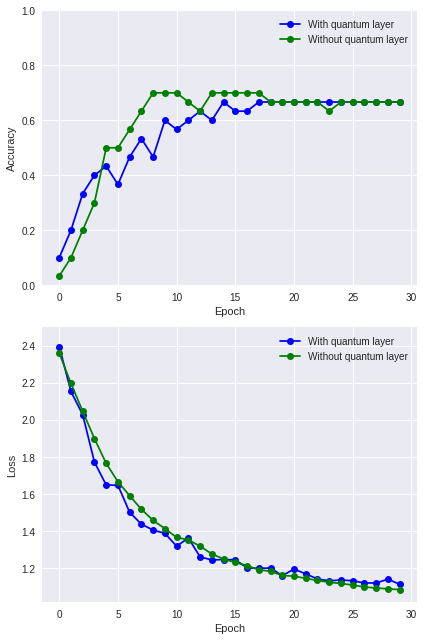

In [17]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()